# Parte 2: Trabajando con el problema de arranque en frio de filtrado basado en contenido (Content-Based Filtering)

El `filtrado colaborativo` se basa en las interacciones del usuario con los items (user-item) dentro de una matriz de utilidad. El problema reside en que los nuevos usuarios o los elementos que no cuenten con interacciones registradas van a ser ignoradas por el sistema de recomendacion. A esto se le conoce como el problema de "Arranque en frio". El filtrado basado en contenido es una manera de atacar este problema al generar recomendaciones en interacciones usuario-item.

En el siguiente ejercicio, generaremos recomendaciones tipo item-item utilizando filtrado basado en contenido.

## The Movies Dataset

Acerca del Conjunto de Datos

Contexto

Estos archivos contienen metadatos para las 45,000 películas enumeradas en el conjunto de datos completo de MovieLens. El conjunto de datos está formado por películas estrenadas hasta julio de 2017. Los puntos de datos incluyen reparto, equipo, palabras clave de la trama, presupuesto, ingresos, carteles, fechas de estreno, idiomas, compañías productoras, países, recuentos de votos de TMDB y promedios de votos.

Este conjunto de datos también tiene archivos que contienen 26 millones de calificaciones de 270,000 usuarios para las 45,000 películas. Las calificaciones están en una escala de 1 a 5 y se han obtenido del sitio web oficial de GroupLens.

Contenido

Este conjunto de datos consta de los siguientes archivos:

    movies_metadata.csv: El archivo principal de metadatos de películas. Contiene información sobre 45,000 películas incluidas en el conjunto de datos completo de MovieLens. Las características incluyen carteles, fondos, presupuesto, ingresos, fechas de estreno, idiomas, países y compañías productoras.
    keywords.csv: Contiene las palabras clave de la trama de la película para nuestras películas MovieLens. Disponible en forma de objeto JSON stringificado.
    credits.csv: Contiene información del reparto y equipo para todas nuestras películas. Disponible en forma de objeto JSON stringificado.
    links.csv: El archivo que contiene los identificadores de TMDB y IMDB de todas las películas del conjunto de datos completo de MovieLens.
    links_small.csv: Contiene los identificadores de TMDB y IMDB de un pequeño subconjunto de 9,000 películas del conjunto de datos completo.
    ratings_small.csv: El subconjunto de 100,000 calificaciones de 700 usuarios en 9,000 películas.

Se puede acceder al conjunto de datos completo de MovieLens, que consta de 26 millones de calificaciones y 750,000 aplicaciones de etiquetas de 270,000 usuarios en las 45,000 películas de este conjunto de datos, aquí.

Agradecimientos

Este conjunto de datos es un conjunto de datos recopilados de TMDB y GroupLens. Los detalles de la película, los créditos y las palabras clave se han recopilado de la API abierta de TMDB. Este producto utiliza la API de TMDb pero no está respaldado ni certificado por TMDb. Su API también brinda acceso a datos sobre muchas películas, actores y actrices adicionales, miembros del equipo y programas de televisión. Puedes probarlo tú mismo aquí.

Los enlaces y las calificaciones de las películas se han obtenido del sitio web oficial de GroupLens. Los archivos forman parte del conjunto de datos disponible aquí:

https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset

### Paso 1: Importar las librerias necesarias

Se utiizaran los siguientes paquetes de Python:

- [numpy](https://numpy.org/): para calculos cientificos
- [pandas](https://pandas.pydata.org/): para manipulacion de dato
- [scikit-learn](https://scikit-learn.org/stable/): para funciones de machine learning 
- [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/): para visualizacion de datos

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process, fuzz
import requests
from io import StringIO

### Paso 2: Cargando los datos

Construiremos nuestro sistema de recomendacion a partir del supuesto de que conocemos muy poco acerca de nuestros usuarios. No contamos con datos suficientes sobre las interacciones con nuestro sistema como para implementar filtrado colaborativo.

Exploremos el dataset para conocer su estructura y las propiedades con las que podemos trabajar.

In [2]:
# permalink:
# https://github.com/JossueGG/tec_bigdata_equipo17/blob/ed9d2ade7ae8703c5c3dbdb8df24d8d457fd6547/ratings_small_entrega2.csv

# Definir la URL del archivo CSV en GitHub
url = 'https://raw.githubusercontent.com/JossueGG/tec_bigdata_equipo17/main/ratings_small_entrega2.csv?token=GHSAT0AAAAAACSA6SWK3XGKAPIOGUDKB2AMZSQ6KKA'

# Leer el archivo CSV desde la URL
response = requests.get(url)
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data)

# Procesar la columna de géneros
def process_genres(genres_str):
    try:
        genres_list = ast.literal_eval(genres_str)
        genres = [genre['name'] for genre in genres_list]
        return '|'.join(genres)
    except (ValueError, SyntaxError):
        return 'No Genre Listed'

df['genres'] = df['genres'].apply(process_genres)

# Crear un nuevo DataFrame con las columnas deseadas
new_df = df[['movieId', 'title', 'genres','year']].drop_duplicates()

#movies = pd.read_csv("datos/movies.csv")
movies = new_df
movies.head()

,movieId,title,genres,year
0,2294,Antz,Adventure|Animation|Comedy|Family,1998
1,1405,Beavis and Butt-Head Do America,Animation|Comedy,1996
2,1287,Ben-Hur,Action|Adventure|Drama|History,1959
3,3671,Blazing Saddles,Western|Comedy,1974
4,1343,Cape Fear,Crime|Thriller,1991


Podemos ver que el dataset cuenta con el id de la pelicula, el titulo, fechas de lanzamiento y los generos asociados a dicha pelicula.

### Paso 3: Limpieza y Exploracion de los Datos

Para este dataset en particular, debemos de limpiar los datos partiendo de las dos siguientes consideraciones:

1. Los generos de las peliculas estan expresados en un string separados por un pipe | . Debemos manipular este string en una lista que nos facilitara el analisis de los datos.
2. El año se extrae de los datos de la metadata

#### Transformando los Generos de un String a una lista


Utilizaremos la funcion "split" para separar los generos de la columna con el mismo nombre. 

Por lo que convertiremos este string:

`"Adventure|Children|Fantasy"`

En un arreglo como este:
`[Adventure, Children, Fantasy]`.

In [3]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres,year
0,2294,Antz,"[Adventure, Animation, Comedy, Family]",1998
1,1405,Beavis and Butt-Head Do America,"[Animation, Comedy]",1996
2,1287,Ben-Hur,"[Action, Adventure, Drama, History]",1959
3,3671,Blazing Saddles,"[Western, Comedy]",1974
4,1343,Cape Fear,"[Crime, Thriller]",1991


#### Calculemos cuantos generos de peliculas contiene el dataset?

Al utilizar la funcion de conteo de Python podemos crear un diccionario que contenga el conteo de frecuencias para cada genero en el dataset.

In [4]:
contador_generos = Counter(g for genres in movies['genres'] for g in genres)
print(f"Existen {len(contador_generos)} tipos de generos.")
contador_generos

movies = movies[movies['genres']!='(no genres listed)']

del contador_generos['(no genres listed)']

Existen 21 tipos de generos.


#### Cuales son los generos de peliculas mas comunes?

Utilizaremos el metodo mas comun de `Counter` que es `most_common()` para obtener el listado de generos con asociados a la mayor cantidad de peliculas.

In [5]:
print("Top 10 de generos de peliculas: \n", contador_generos.most_common(10))

Top 10 de generos de peliculas: 
 [('Drama', 4604), ('Comedy', 3366), ('Thriller', 1997), ('Romance', 1843), ('Action', 1749), ('Crime', 1245), ('Adventure', 1193), ('Horror', 912), ('Science Fiction', 858), ('Family', 857)]


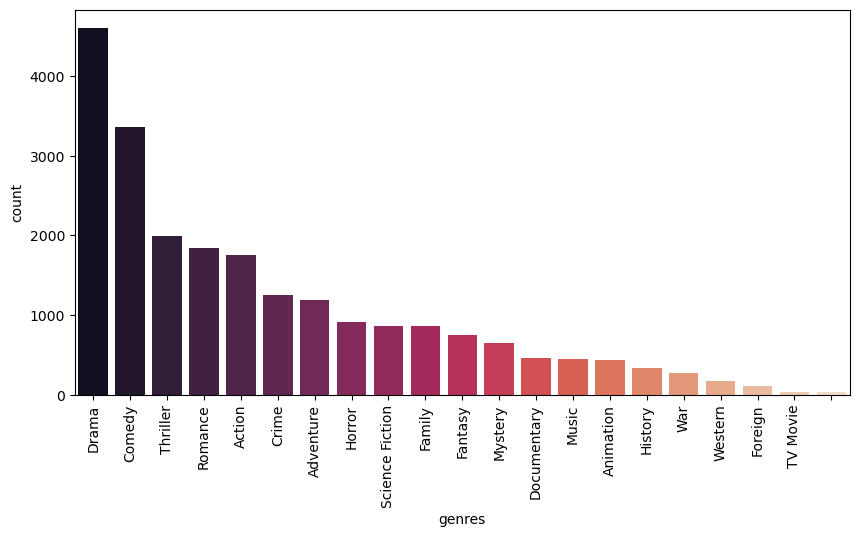

In [6]:
genres_counts_df = pd.DataFrame([contador_generos]).T.reset_index()
genres_counts_df.columns = ['genres', 'count']
genres_counts_df = genres_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='genres', y='count', data=genres_counts_df, palette='rocket')
plt.xticks(rotation=90)
plt.show()

La grafica nos confirma lo que descubrimos anteriormente, `Drama` y `Comedia` son los generos mas populares mientras que los `Westerns`, `Foreing`, and `TV-Movie` son los menos populares.

#### Cuantos año distintos estan contenidos en nuestro dataset?


In [7]:
unique_years = movies['year'].nunique()
print(f"Total de años distintos en nuestro dataset: {unique_years}")

Total de años distintos en nuestro dataset: 103


Con este calculo rapido, nos percatamos que contamos con mas de 100 años en nuestro dataset. Lo que podemos hacer ahora es dividir nuestros datos en decadas para tener una idea en general de cuando fueron lanzadas las peliculas de nuestro dataset.

#### Cual fue la decada mas popular para estrenar una pelicula?

Analizemos el dataset para conocer el numero de peliculas contenidas.

In [8]:
print(f"Numero total de peliculas en el dataset: {movies['movieId'].nunique()}")

Numero total de peliculas en el dataset: 9025


Ahora limpiemos nuestro dataset al eliminar todas las peliculas que contengan un `null` en el año.

In [9]:
movies = movies[~movies['year'].isnull()]
print(f"Total de peliculas despues de eliminar aquellas con null en el año:: {movies['movieId'].nunique()}")


Total de peliculas despues de eliminar aquellas con null en el año:: 9025


El dataset está completo

In [10]:
x = 1995

def calcular_decada(year):
    year = str(year)
    decade_prefix = year[0:3] # obtener los primeros 3 digitos de un año
    decade = f'{decade_prefix}0' # añadir un 0 al final
    return int(decade)

calcular_decada(x)

1990

In [11]:
def redondear(year):
    return year - (year%10)

redondear(x)

1990

Ambas funciones `calcular_decada()` y `redondear()` cumplen con el objetivo de identificar la decada de un año.

Podemos aplicar cualquiera de ellas a todos los años de nuestro dataset `movies` y al mismo tiempo crearemos una columna llamada `decade`.


In [12]:
movies['decade'] = movies['year'].apply(redondear)

In [13]:
movies

,movieId,title,genres,year,decade
0,2294,Antz,"[Adventure, Animation, Comedy, Family]",1998,1990
1,1405,Beavis and Butt-Head Do America,"[Animation, Comedy]",1996,1990
2,1287,Ben-Hur,"[Action, Adventure, Drama, History]",1959,1950
3,3671,Blazing Saddles,"[Western, Comedy]",1974,1970
4,1343,Cape Fear,"[Crime, Thriller]",1991,1990
...,...,...,...,...,...
98810,60832,Pathology,"[Crime, Horror, Thriller]",2008,2000
98920,72380,The Box,"[Thriller, Science Fiction]",2009,2000
99295,129,Pie in the Sky,"[Comedy, Romance]",1996,1990
99368,4736,Summer Catch,"[Drama, Comedy, Romance]",2001,2000


### Paso 4: Transformando los datos

Para construir un sistema de recomendacion con filtrado basado en contenido necesitamos preparar nuestro dataset de forma tal que las filas representen las peliculas y las columnas las caracteristicas (generos y decadas)


Primero, debemos manipular la columna de `generos` de forma tal que cada genero sea representado por una caracteristica binaria (1 si pertenece a un determinado genero, 0 si no pertenece)

In [14]:
genres = list(contador_generos.keys())

for g in genres:
    movies[g] = movies['genres'].transform(lambda x: int(g in x))

Analizando la estructura de los datos se desplieguan de la siguiente manera:

In [15]:
movies[genres].head()

,Adventure,Animation,Comedy,Family,Action,Drama,History,Western,Crime,Thriller,...,Horror,Science Fiction,Mystery,War,Fantasy,Music,Documentary,,Foreign,TV Movie
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


Con esto comprobamos que los generos se representan como columnas con propiedades binarias. Ahora debemos asignar las distintas decadas a sus columnas correspondientes. Lo realizamos al utilizar la funcion `get_dummies()` de `pandas` al crear variables categoricas en variables binarias.

In [16]:
movie_decades = pd.get_dummies(movies['decade'])
movie_decades.head()

,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010
0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0


Lo siguiente es crear un nuevo dataframe con las propiedades de de decada y genero de las peliculas en `movie_features`. Lo conseguimos al utilizar la funcion `concat` de pandas, al concatenar los generos y las decadas en un solo dataframe.

In [17]:
movie_features = pd.concat([movies[genres], movie_decades], axis=1)
movie_features.head()

,Adventure,Animation,Comedy,Family,Action,Drama,History,Western,Crime,Thriller,...,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,1,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0


El dataframe `movie_features` esta listo y contiene los datos que nos interesan. Ahora debemos de construir nuestro sistema de recomendacion.

### Step 5: Construyendo un sistema de recomendacion de "Peliculas Parecidas" utilizando similitud Coseno

Para construir este sistema de recomendacion item-item utilizaremos una metrica llamada similitud coseno `cosine similarity`.

La similitud Coseno se basa en el coseno del angulo entre dos vectores (c.e., $A$ y $B$). Entre mas pequeño es el angulo, mayor es la similitud entre los vectores, y se calcula de la siguiente forma:

$$\cos(\theta) = \frac{A\cdot B}{||A|| ||B||}$$

En este ejercicio, utilizaremos la funcion de scikit-learn de `cosine_similarity` para generar la matriz de similitud de tipo $(n_{\text{movies}}, n_{\text{movies}})$. Esta matriz nos permitira extraer peliculas que sean parecidas a nuestra pelicula de interes.

In [18]:
cosine_sim = cosine_similarity(movie_features, movie_features)
print(f"Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: {cosine_sim.shape}")

Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: (9025, 9025)


Esto nos indica que al evaluar la similitud de coseno del dataframe `movie_features` en la funcion `cosine_similarity()` obtenemos una matriz de similitud del tipo $(n_{\text{movies}}, n_{\text{movies}})$.

Esta matriz contiene valores entre 0 y 1 que representan el angulo de similaridad entre las peliculas en los ejes x , y.


### Desarrollando una funcion que encuentre peliculas similares

Si por ejemplo queremos encontrar peliculas que sean similares a `Antz` en nuestro sistema de recomendacion, necesitamos saber el titulo de una pelicula en nuestro dataset.

Afortunadamente la pelicula esta listada como `'Antz'`. Sin embargo, si deletreamos mal el nombre u olvidamos incluir el año de su lanzamiento, el sistema no sabra que pelicula es a la que nos estamos refiriendo.

Con el fin de que nuestro sistema sea mas amigable para el usuario, utilizaremos un paquete llamado `fuzzywuzzy` que nos ayudara a encontrar el titulo de la pelicula mas parecido a partir del string que le pasemos. 

Con base en esto, crearemos una funcion que se llame `encuentra_pelicula()` que implementa el algoritmo de matching de strings de `fuzzywuzzy` para hallar el titulo mas parecido a partir de un string ingresado por el usuario.

In [19]:
def encuentra_pelicula(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [20]:
# def encuentra_pelicula(title, threshold=95):
#     all_titles = movies['title'].tolist()
    
#     # Uso de token_set_ratio para buscar la mejor coincidencia
#     best_match = process.extractOne(title, all_titles, scorer=fuzz.token_set_ratio)
    
#     if best_match[1] >= threshold:
#         return best_match[0]
#     else:
#         return "No se encontró una coincidencia adecuada"

# # Probar con el título "Ants"
# title = encuentra_pelicula('Ants')
# print(f"El título correcto de la película es: {title}")

Probemos la funcionalidad de la funcion `encuentra_pelicula()` al escribir equivocadamente la pelicula `Antz`

In [21]:
title = encuentra_pelicula('spongeBob')
print(f"El titulo correcto de la pelicula es: {title}")

El titulo correcto de la pelicula es: The SpongeBob SquarePants Movie


Ahora que ya no nos preocupamos por escribir mal el titulo de una pelicula, lo que nos interesa es encontrar recomendaciones relevantes a partir de la pelicula que deseamos.

Deseamos encontrar el indice de la pelicula en la matriz de similitud coseno. Para identificar la fila en la cual debemos buscar podemos crear un mapeador de indices de peliculas que encuentre el titulo de una pelicula y le asigne el indice que representa en nuestra matriz.

Crearemos un diccionario llamado `movie_idx` donde las llaves son los titulos de las peliculas y los valores son los indices de las peliculas.

In [22]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"El indice de la pelicula {title} en la matriz movie_idx es: {idx}")

El indice de la pelicula The SpongeBob SquarePants Movie en la matriz movie_idx es: 2452


Al usar el diccionario `movie_idx`, sabemos que Jumanji se representa por el indice 1 en nuestra matriz. 

Ahora tratemos de encontrar las 10 peliculas mas similares a Jumanji.

In [23]:
numero_recomendaciones=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(numero_recomendaciones+1)]
similar_movies = [i[0] for i in sim_scores]

`similar_movies` es un arreglo de indices que representa el top 10 de recomendaciones a partir de la pelicula elegida (en este caso Jumanji). Podemos encontrar el titulos de las peliculas correspondientes al crear un mapeador invertido de `movie_idx` o usando `iloc` en la columna de titulo del dataframe `movies`.

In [24]:
print(f"Por que miraste la pelicula {title}, te pueden interesar las siguientes {numero_recomendaciones} peliculas:")
movies['title'].iloc[similar_movies]

Por que miraste la pelicula The SpongeBob SquarePants Movie, te pueden interesar las siguientes 10 peliculas:


1763            Michael Clayton
2250               The Deep End
4225                      Gerry
10726            Gone Baby Gone
12760             Paranoid Park
12816          The White Ribbon
14307                Changeling
54304       The Weight of Water
90002    Merci pour le Chocolat
11591           The Proposition
Name: title, dtype: object

Podemos probar nuestro sistema con otros titulos de peliculas. 

In [25]:
def obtener_recomendaciones_basadas_contenido(title_string, numero_recomendaciones=10):
    title = encuentra_pelicula(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(numero_recomendaciones+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Las peliculas recomendadas con base en la pelicula {title} son:")
    print(movies['title'].iloc[similar_movies])

In [26]:
obtener_recomendaciones_basadas_contenido('aladin', 5)

Las peliculas recomendadas con base en la pelicula Aladdin son:
5381                    Hercules
9593     All Dogs Go to Heaven 2
10232              A Goofy Movie
55619           The Book of Life
0                           Antz
Name: title, dtype: object
